<a href="https://colab.research.google.com/github/nuoweili/personal-project/blob/main/proj_temp_seq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
'''
from google.colab import files
uploaded = files.upload()
'''

Saving temperatures-2025.pkl to temperatures-2025 (1).pkl


In [ ]:
def load_data(picklefile):
  import pickle
  f = open(picklefile, "rb")
  data = pickle.load(f)
  f.close()
  return data
(train_seq, val_seq, test_seq) = load_data("temperatures-2025.pkl")

In [ ]:
x_train, y_train = train_seq[:, :72, :], train_seq[:, 72:, :]
x_val, y_val = val_seq[:, :72, :], val_seq[:, 72:, :]
x_test, y_test = test_seq[:, :72, :], test_seq[:, 72:, :]

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import random

def display_temperatures(x, y_true, y_pred=None, num_samples=3, title="Temperature Sequences"):

  fig, axes = plt.subplots(1, num_samples, figsize=(18, 4))
  for i in range(num_samples):
    idx = random.randint(0, len(x) - 1)

    #past data(72)
    past_seq = x[idx]
    true_future = y_true[idx]

    axes[i].plot( np.arange(len(past_seq)), past_seq[:, 0],
                 color='blue',
                 alpha=0.6
                  )
    axes[i].plot(np.arange(len(past_seq)), past_seq[:, 1],
                 color='red',
                 alpha=0.6
                 )

    #ground truth future
    axes[i].plot(np.arange(len(past_seq), len(past_seq) + len(true_future)),
                 true_future[:, 0],
                 label="true min",
                 color='blue',
                 )
    axes[i].plot(np.arange(len(past_seq), len(past_seq) + len(true_future)),
                 true_future[:, 1],
                 label="true max",
                 color='red',
                 )

    #predicted future
    if y_pred is not None:
      pred_future = y_pred[idx]
      axes[i].plot(np.arange(len(past_seq), len(past_seq) + len(pred_future)),
                   pred_future[:, 0],
                   label="pred min (predicted)",
                   color='black',
                   linestyle='--'
                   )
      axes[i].plot(np.arange(len(past_seq), len(past_seq) + len(pred_future)),
                   pred_future[:, 1],
                   label="pred max (predicted)",
                   color='green',
                   linestyle='--'
                   )

    axes[i].axvline(x=len(past_seq)-1, color='gray', linestyle='--')
    axes[i].set_title(f"Sample {i+1}")
    axes[i].set_xlabel("Time steps")
    axes[i].set_ylabel("Temperature")


  handles, labels = axes[0].get_legend_handles_labels()
  fig.legend(handles, labels, loc='upper right')
  fig.suptitle(title, fontsize=14)
  plt.tight_layout()
  plt.show()


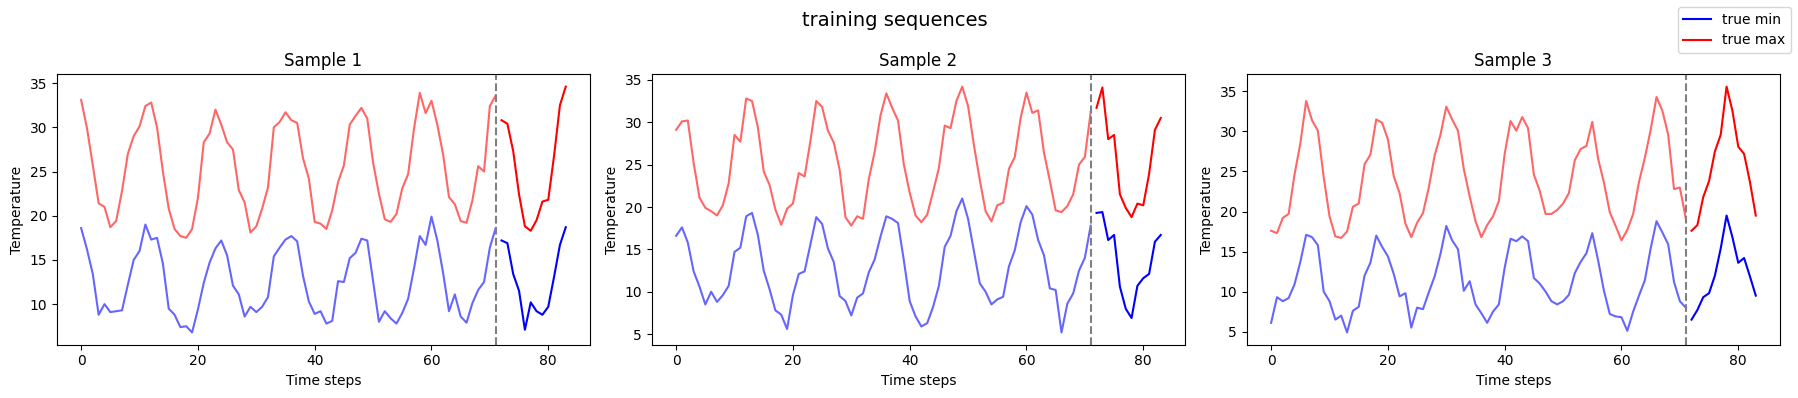

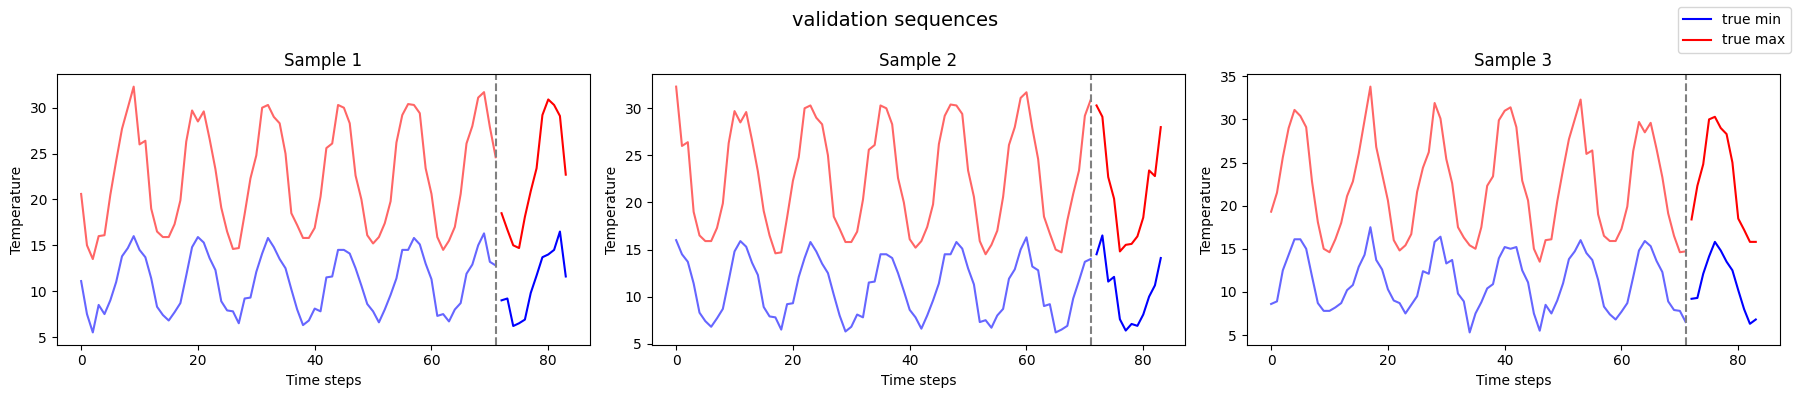

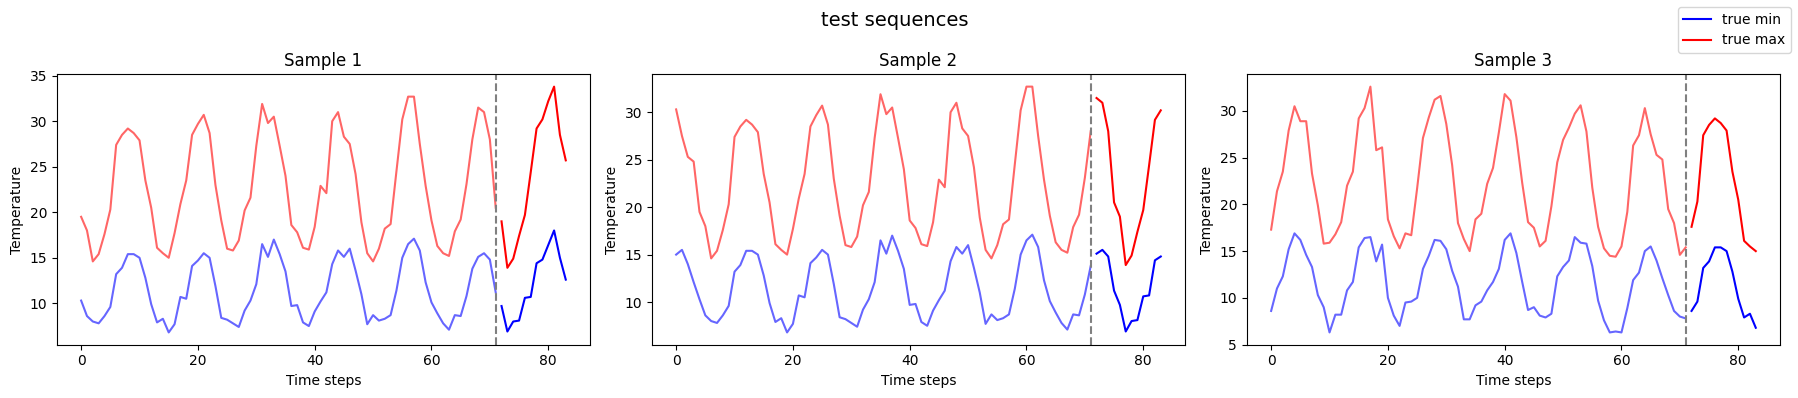

In [ ]:
display_temperatures(x_train, y_train, title="training sequences")
display_temperatures(x_val, y_val, title="validation sequences")
display_temperatures(x_test, y_test, title="test sequences")

In [ ]:
#normalization
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

train_seq_np = train_seq.numpy()
val_seq_np   = val_seq.numpy()
test_seq_np  = test_seq.numpy()

train_scaled = scaler.fit_transform(train_seq_np.reshape(-1, 2)).reshape(train_seq.shape)
val_scaled   = scaler.transform(val_seq_np.reshape(-1,2)).reshape(val_seq.shape)
test_scaled  = scaler.transform(test_seq_np.reshape(-1,2)).reshape(test_seq.shape)


x_train_n, y_train_n = train_scaled[:, :72, :], train_scaled[:, 72:, :]
x_val_n, y_val_n = val_scaled[:, :72, :], val_scaled[:, 72:, :]
x_test_n, y_test_n = test_scaled[:, :72, :], test_scaled[:, 72:, :]



x_train_n = tf.convert_to_tensor(x_train_n, dtype=tf.float32)
y_train_n = tf.convert_to_tensor(y_train_n, dtype=tf.float32)
x_val_n = tf.convert_to_tensor(x_val_n, dtype=tf.float32)
y_val_n = tf.convert_to_tensor(y_val_n, dtype=tf.float32)
x_test_n = tf.convert_to_tensor(x_test_n, dtype=tf.float32)
y_test_n = tf.convert_to_tensor(y_test_n, dtype=tf.float32)

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras import models
import time
import numpy as np
import random
tf.random.set_seed(42)
output_len = 12

model1 = models.Sequential([
    layers.GRU(16, return_sequences=True, input_shape=(None, 2), activation='tanh'),
    layers.GRU(16, activation='tanh'),
    layers.Dense(output_len*2),
    layers.Reshape((output_len, 2))
    ])
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
      initial_learning_rate=0.01,
      decay_steps=10_000,
      decay_rate=1.0,
      staircase=False
      )
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

model1.compile(optimizer=optimizer, loss='mae', metrics=['mae'])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
model1.summary()

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_48 (GRU)                    │ (None, None, 16)       │           960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_49 (GRU)                    │ (None, 16)             │         1,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 24)             │           408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_14 (Reshape)            │ (None, 12, 2)          │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,001 (35.16 KB)

 Trainable params: 3,000 (11.72 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 6,001 (23.45 KB)

In [ ]:
tf.random.set_seed(42)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
history = model1.fit(x_train_n, y_train_n,
                     epochs=100,
                     validation_data=(x_val_n, y_val_n),
                     callbacks=[early_stopping_cb],
                     verbose=0)

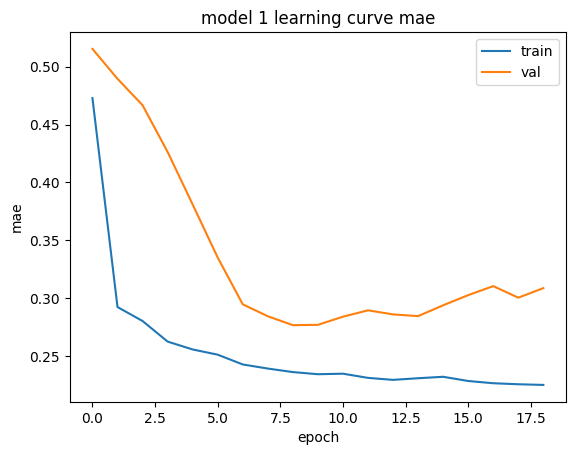

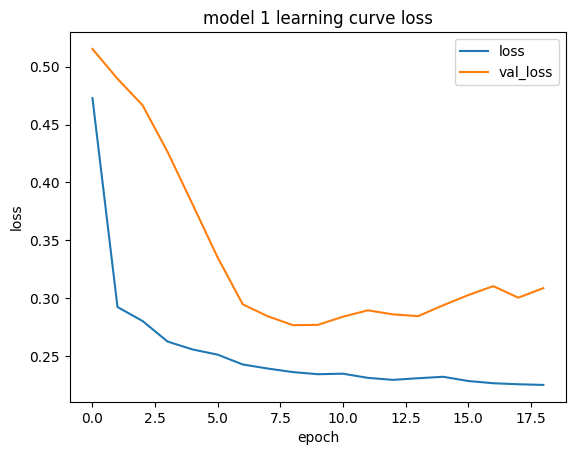

In [ ]:
plt.plot(history.history['mae'], label='train')
plt.plot(history.history['val_mae'], label='val')
plt.legend()
plt.title('model 1 learning curve mae')
plt.xlabel('epoch')
plt.ylabel('mae')
plt.show()
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.title('model 1 learning curve loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1.2310202
0.2741123


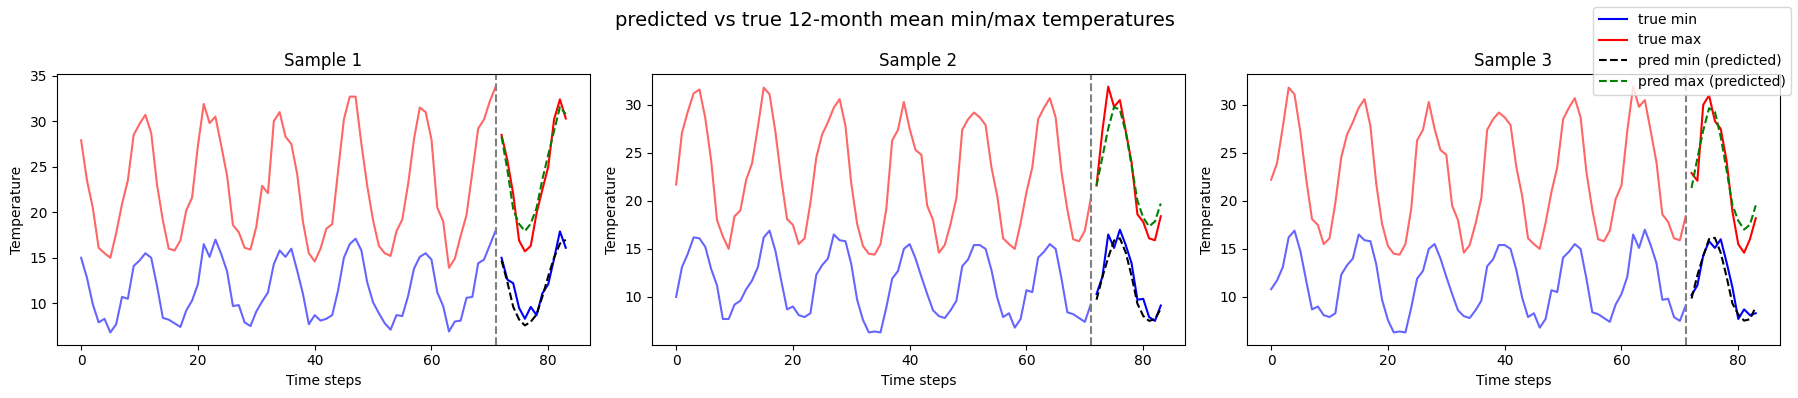

In [ ]:
# Predict
y_pred = model1.predict(x_test_n)


#inverse transform
y_pred_it = scaler.inverse_transform(y_pred.reshape(-1, 2)).reshape(y_pred.shape)



test_mae = np.mean(np.abs(y_test.numpy() - y_pred_it))
tmn = np.mean(np.abs(y_test_n.numpy() - y_pred))
print(test_mae)
print(tmn)


display_temperatures(x_test, y_test, y_pred_it, num_samples=3,
                     title="predicted vs true 12-month mean min/max temperatures")

In [ ]:
y_train_1 = y_train_n[:, 0:1, :]
y_val_1 = y_val_n[:, 0:1, :]
y_test_1 = y_test_n[:, 0:1, :]

In [ ]:
model2 = models.Sequential([
    layers.GRU(16, return_sequences=True, input_shape=(None, 2), activation='tanh'),
    layers.GRU(16, activation='tanh'),
    layers.Dense(2),
    layers.Reshape((1, 2))
])

optimizer = keras.optimizers.Adam(learning_rate=0.001)
model2.compile(optimizer=optimizer, loss='mae', metrics=['mae'])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
history2 = model2.fit(x_train_n, y_train_1,
                      epochs=100,
                      validation_data=(x_val_n, y_val_1),
                      callbacks=[early_stopping_cb],
                      verbose=0)

In [ ]:
model2.summary()

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_50 (GRU)                    │ (None, None, 16)       │           960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_51 (GRU)                    │ (None, 16)             │         1,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 2)              │            34 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_15 (Reshape)            │ (None, 1, 2)           │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,880 (30.79 KB)

 Trainable params: 2,626 (10.26 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 5,254 (20.53 KB)

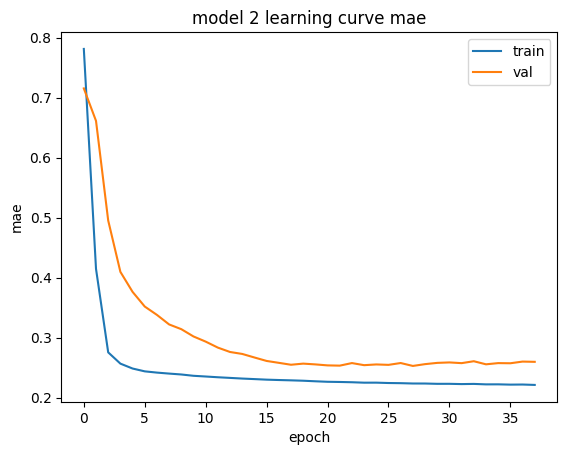

Text(0, 0.5, 'loss')

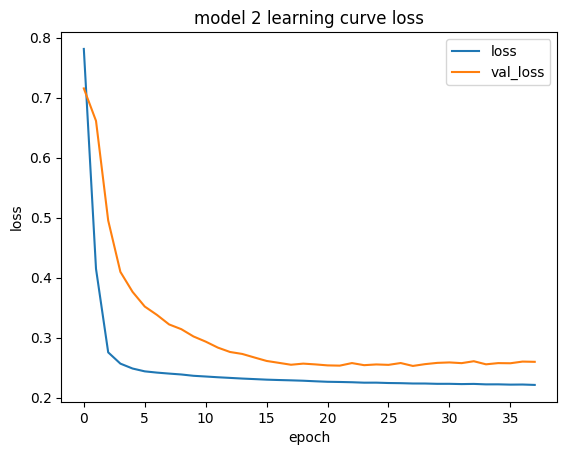

In [ ]:
plt.plot(history2.history['mae'], label='train')
plt.plot(history2.history['val_mae'], label='val')
plt.legend()
plt.title('model 2 learning curve mae')
plt.xlabel('epoch')
plt.ylabel('mae')
plt.show()

plt.plot(history2.history['loss'], label='loss')
plt.plot(history2.history['val_loss'], label='val_loss')
plt.legend()
plt.title('model 2 learning curve loss')
plt.xlabel('epoch')
plt.ylabel('loss')

In [ ]:
def predict_12_months_loop(model, x_input, i=12):

  X = x_input.numpy().copy()
  predictions = []

  for step in range(i):
    #predict next month
    y_pred_one = model.predict(X, verbose=0)
    predictions.append(y_pred_one)

    #concatrenate the prediction
    X = np.concatenate([X, y_pred_one], axis=1)

  #concatenate all prediction
  predictions = np.concatenate(predictions, axis=1)
  return predictions

test mae normalised: 0.3000
test mae: 1.3381


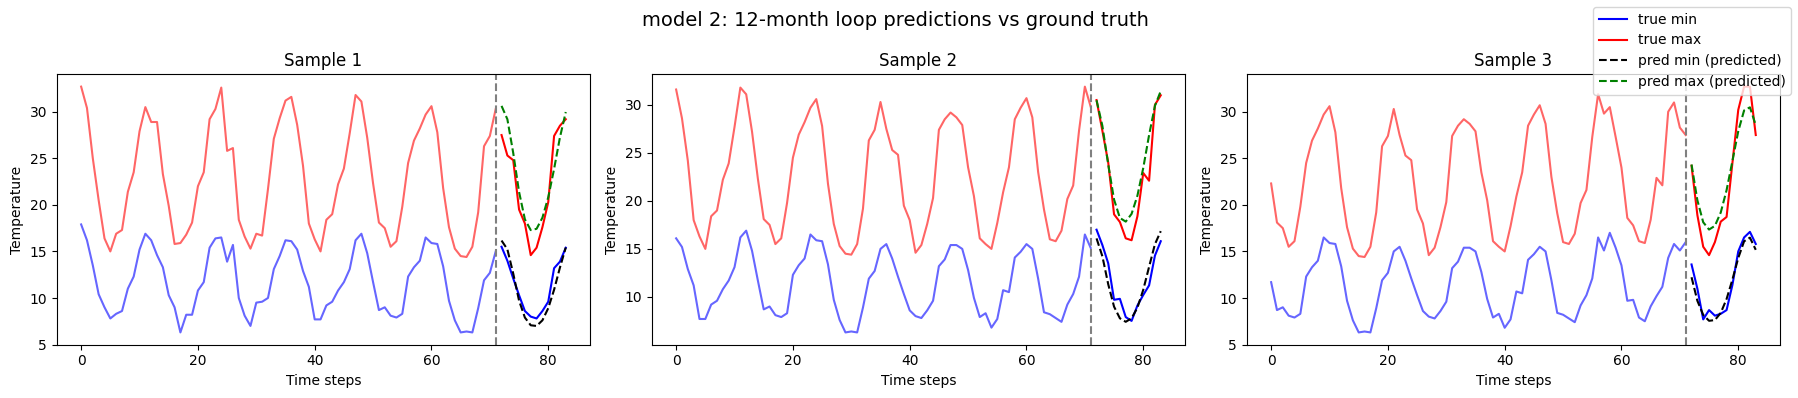

In [ ]:
y_pred_12_n = predict_12_months_loop(model2, x_test_n)

#inverse transform
y_pred_12 = scaler.inverse_transform(y_pred_12_n.reshape(-1, 2)).reshape(-1, 12, 2)

test_mae_normalized2 = np.mean(np.abs(y_test_n.numpy() - y_pred_12_n))
test_mae2 = np.mean(np.abs(y_test.numpy() - y_pred_12))

print(f"test mae normalised: {test_mae_normalized2:.4f}")
print(f"test mae: {test_mae2:.4f}")


#rescale
y_pred_12 = scaler.inverse_transform(y_pred_12_n.reshape(-1, 2)).reshape(-1, 12, 2)

display_temperatures(x_test, y_test, title="model 2: 12-month loop predictions vs ground truth",
                     num_samples=3,
                     y_pred=y_pred_12)

In [ ]:
x_train_decode = tf.concat([tf.zeros((y_train_n.shape[0], 1, 2)),
                            y_train_n[:, :-1, :]
                            ], axis=1)

x_val_decode = tf.concat([tf.zeros((y_val_n.shape[0], 1, 2)),
                          y_val_n[:, :-1, :]
                          ], axis=1)

x_test_decode = tf.concat([tf.zeros((y_test_n.shape[0], 1, 2)),
                           y_test_n[:, :-1, :]
                           ], axis=1)

In [ ]:

encoder_inputs = tf.keras.Input(shape=[None, 2])

encoder_gru1 = layers.GRU(8, return_sequences=True, return_state=True,
                          activation='leaky_relu')
encoder_seq1, encoder_state1 = encoder_gru1(encoder_inputs)

encoder_gru2 = layers.GRU(8, return_sequences=True, return_state=True,
                          activation='leaky_relu')
encoder_outputs, encoder_state2 = encoder_gru2(encoder_seq1)

encoder_state = tf.keras.layers.Concatenate(axis=-1)([encoder_state1, encoder_state2])




print(f"\nEncoder state1 shape: {encoder_state1.shape}")
print(f"Encoder state2 shape: {encoder_state2.shape}")

print(f"\nEncoder state shape: {encoder_state.shape}")

decoder_inputs = tf.keras.Input(shape=[None, 2])

decoder_gru1 = layers.GRU(16, return_sequences=True,return_state=True,
                          activation='leaky_relu')
decoder_seq1, ds1= decoder_gru1(decoder_inputs, initial_state=encoder_state)

decoder_gru2 = layers.GRU(16, return_sequences=True,
                          activation='leaky_relu')
decoder_outputs= decoder_gru2(decoder_seq1)

print(f"\ndecoder state1 shape: {ds1.shape}")

outputs = layers.Dense(2)(decoder_outputs)

model3 = tf.keras.Model(inputs=[encoder_inputs, decoder_inputs],
outputs=outputs)

optimizer = keras.optimizers.Adam(learning_rate=0.001)
model3.compile(optimizer=optimizer, loss='mae', metrics=['mae'])


Encoder state1 shape: (None, 8)
Encoder state2 shape: (None, 8)

Encoder state shape: (None, 16)

decoder state1 shape: (None, 16)


In [ ]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
monitor='val_loss', patience=10, restore_best_weights=True)

history3 = model3.fit(
    (x_train_n, x_train_decode), y_train_n,
    epochs=100,
    validation_data=((x_val_n, x_val_decode), y_val_n),
    callbacks=[early_stopping_cb],
    verbose=0
)

In [ ]:
model3.summary()

Model: "functional_35"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_28      │ (None, None, 2)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_52 (GRU)        │ [(None, None, 8), │        288 │ input_layer_28[0… │
│                     │ (None, 8)]        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_53 (GRU)        │ [(None, None, 8), │        432 │ gru_52[0][0]      │
│                     │ (None, 8)]        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_29      │ (None, None, 2)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_5       │ (None, 16)        │          0 │ gru_52[0][1],     │
│ (Concatenate)       │                   │            │ gru_53[0][1]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_54 (GRU)        │ [(None, None,     │        960 │ input_layer_29[0… │
│                     │ 16), (None, 16)]  │            │ concatenate_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_55 (GRU)        │ (None, None, 16)  │      1,632 │ gru_54[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_28 (Dense)    │ (None, None, 2)   │         34 │ gru_55[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 10,040 (39.22 KB)

 Trainable params: 3,346 (13.07 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 6,694 (26.15 KB)

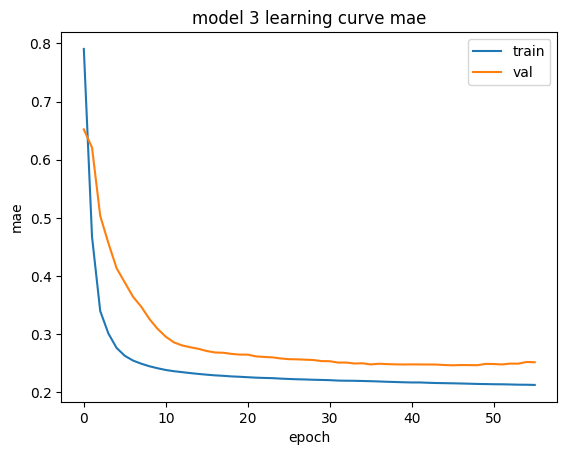

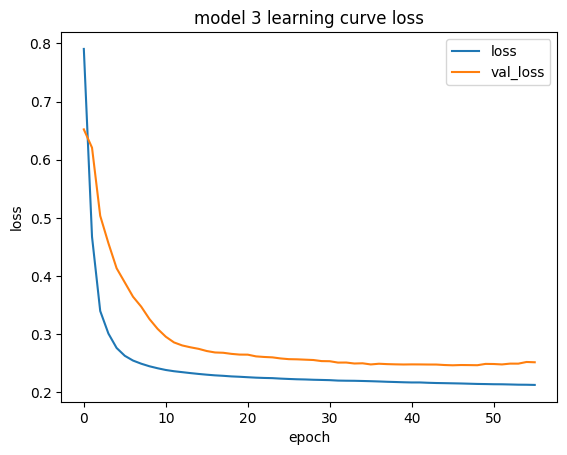

In [ ]:
plt.plot(history3.history['mae'], label='train')
plt.plot(history3.history['val_mae'], label='val')
plt.legend()
plt.title('model 3 learning curve mae')
plt.xlabel('epoch')
plt.ylabel('mae')
plt.show()

plt.plot(history3.history['loss'], label='loss')
plt.plot(history3.history['val_loss'], label='val_loss')
plt.legend()
plt.title('model 3 learning curve loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [ ]:
def predict_model3(model, encoder_inputs, decoder_input, outseq_len, **kwargs):

  batch_size = encoder_inputs.shape[0]
  out_dim = decoder_input.shape[-1]
  # the output sequence to be predicted
  outseq = np.zeros((batch_size, outseq_len, out_dim))
  # construct the inputs for the decoder
  decoder_ins = np.zeros((batch_size, outseq_len, out_dim))
  decoder_ins[:, 0, :] = decoder_input
  for t in range(outseq_len):
    # call model.predict(...) and update decoder_ins and outseq
    current_decoder_input = decoder_ins[:, :t+1, :]
    predictions = model.predict([encoder_inputs, current_decoder_input], verbose=0)
    outseq[:, t, :] = predictions[:, -1, :]
    if t < outseq_len - 1:
      decoder_ins[:, t+1, :] = outseq[:, t, :]

  return outseq

test mae (normalized) = 0.3076
test mae (not normalized) = 1.3678


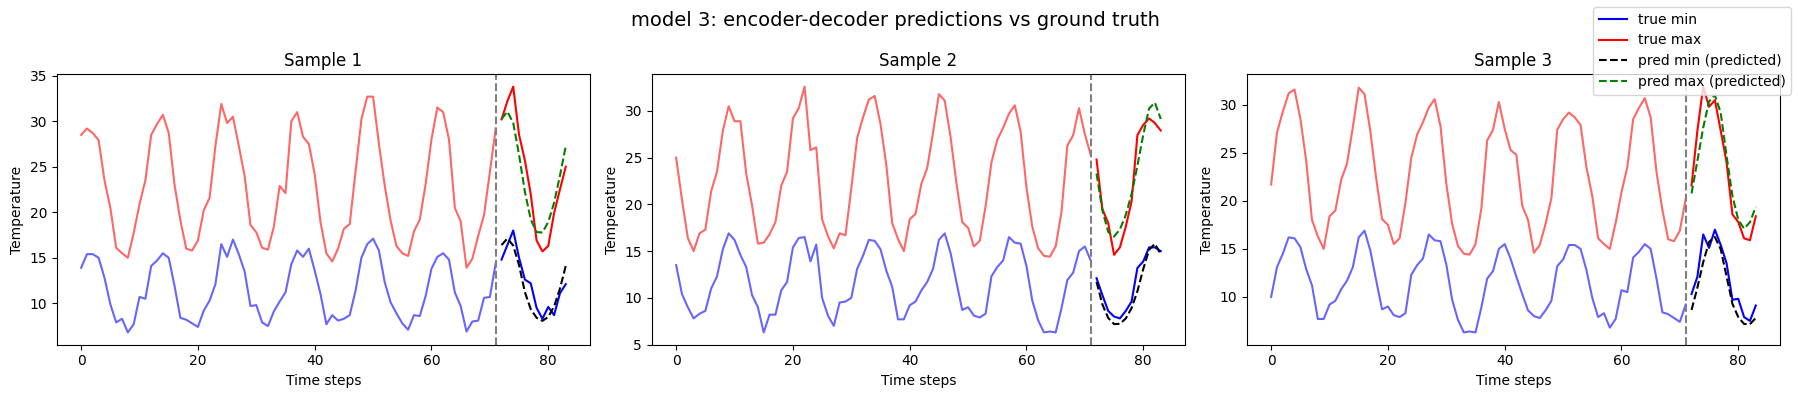

In [ ]:
decoder_start_test = x_test_n[:, -1, :]
x_test, y_test = test_seq[:, :72, :], test_seq[:, 72:, :]

y_pred3_n = predict_model3(model3, x_test_n, decoder_start_test, outseq_len=12)

test_mae_normalized3 = np.mean(np.abs(y_test_n.numpy() - y_pred3_n))
print(f"test mae (normalized) = {test_mae_normalized3:.4f}")

#inverse transform
y_pred3 = scaler.inverse_transform(y_pred3_n.reshape(-1, 2)).reshape(-1, 12, 2)
test_mae_3 = np.mean(np.abs(y_test.numpy() - y_pred3))

print(f"test mae (not normalized) = {test_mae_3:.4f}")


display_temperatures(x_test, y_test,
                    title="model 3: encoder-decoder predictions vs ground truth",
                    num_samples=3,
                    y_pred=y_pred3)

In [ ]:
def split_seq(seq, n):
  x, y = seq[:, :n, :], seq[:, n:, :]
  x = tf.convert_to_tensor(x, dtype=tf.float32)
  y = tf.convert_to_tensor(y, dtype=tf.float32)
  return x, y

train_seq_np = train_seq.numpy()
val_seq_np   = val_seq.numpy()
test_seq_np  = test_seq.numpy()

train_scaled = scaler.fit_transform(train_seq_np.reshape(-1, 2)).reshape(train_seq.shape)
val_scaled   = scaler.transform(val_seq_np.reshape(-1,2)).reshape(val_seq.shape)
test_scaled  = scaler.transform(test_seq_np.reshape(-1,2)).reshape(test_seq.shape)

x_train66, y_train66 = split_seq(train_scaled, 66)
x_val66, y_val66 = split_seq(val_scaled, 66)
x_test66, y_test66 = split_seq(test_scaled, 66)

x_train60, y_train60 = split_seq(train_scaled, 60)
x_val60, y_val60 = split_seq(val_scaled, 60)
x_test60, y_test60 = split_seq(test_scaled, 60)

x_train54, y_train54 = split_seq(train_scaled, 54)
x_val54, y_val54 = split_seq(val_scaled, 54)
x_test54, y_test54 = split_seq(test_scaled, 54)

x_train48, y_train48 = split_seq(train_scaled, 48)
x_val48, y_val48 = split_seq(val_scaled, 48)
x_test48, y_test48 = split_seq(test_scaled, 48)

datalist = [[x_train66, y_train66, x_val66, y_val66, x_test66, y_test66, 18],
            [x_train60, y_train60, x_val60, y_val60, x_test60, y_test60, 24],
            [x_train54, y_train54, x_val54, y_val54, x_test54, y_test54, 30],
            [x_train48, y_train48, x_val48, y_val48, x_test48, y_test48, 36]]


In [ ]:
mae1 = [test_mae]
for i in range(len(datalist)):
  x_train, y_train, x_val, y_val, x_test, y_test,  ol= datalist[i]

  output_len = ol

  model_1 = models.Sequential([
      layers.GRU(16, return_sequences=True, input_shape=(None, 2), activation='tanh'),
      layers.GRU(16, activation='tanh'),
      layers.Dense(ol*2),
      layers.Reshape((ol, 2))
      ])
  lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
        initial_learning_rate=0.01,
        decay_steps=10_000,
        decay_rate=1.0,
        staircase=False
        )
  optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

  model_1.compile(optimizer=optimizer, loss='mae', metrics=['mae'])

  early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
  history = model_1.fit(x_train, y_train,
                      epochs=100,
                      validation_data=(x_val, y_val),
                      callbacks=[early_stopping_cb],
                      verbose=0)
  y_pred =  model_1.predict(x_test)

  y_test_it = scaler.inverse_transform(y_test.numpy().reshape(-1, 2)).reshape(y_test.shape)
  y_pred_it = scaler.inverse_transform(y_pred.reshape(-1, 2)).reshape(y_pred.shape)

  test_mae = np.mean(np.abs(y_test_it - y_pred_it))
  mae1.append(test_mae)

print(mae1)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
[np.float32(1.2310202), np.float32(1.2309579), np.float32(1.1090732), np.float32(1.2447424), np.float32(1.2345141)]


In [ ]:
mae2 = [test_mae2]
for i in range(len(datalist)):
  x_train, y_train, x_val, y_val, x_test, y_test,  ol= datalist[i]
  y_train_i = y_train[:, 0:1, :]
  y_val_i = y_val[:, 0:1, :]
  y_test_i = y_test[:, 0:1, :]

  model_2 = models.Sequential([
    layers.GRU(16, return_sequences=True, input_shape=(None, 2), activation='tanh'),
    layers.GRU(16, activation='tanh'),
    layers.Dense(2),
    layers.Reshape((1, 2))
    ])

  optimizer = keras.optimizers.Adam(learning_rate=0.001)
  model_2.compile(optimizer=optimizer, loss='mae', metrics=['mae'])

  early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
  history2 = model_2.fit(x_train, y_train_i,
                        epochs=100,
                        validation_data=(x_val, y_val_i),
                        callbacks=[early_stopping_cb],
                        verbose=0)

  y_pred_i = predict_12_months_loop(model_2, x_test, ol)

  y_pred_it = scaler.inverse_transform(y_pred_i.reshape(-1, 2)).reshape(y_pred_i.shape)
  y_test_it = scaler.inverse_transform(y_test.numpy().reshape(-1, 2)).reshape(y_test.shape)

  test_mae = np.mean(np.abs(y_test_it - y_pred_it))
  mae2.append(test_mae)

print(mae2)



/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a l

[np.float32(1.3381144), np.float32(1.2307527), np.float32(1.3847725), np.float32(1.3870778), np.float32(1.5333545)]


In [ ]:
mae3 = [test_mae_3]
for i in range(len(datalist)):
  x_train, y_train, x_val, y_val, x_test, y_test,  ol= datalist[i]
  x_train_decode = tf.concat([tf.zeros((y_train.shape[0], 1, 2)),
                            y_train[:, :-1, :]
                            ], axis=1)

  x_val_decode = tf.concat([tf.zeros((y_val.shape[0], 1, 2)),
                            y_val[:, :-1, :]
                            ], axis=1)

  x_test_decode = tf.concat([tf.zeros((y_test.shape[0], 1, 2)),
                            y_test[:, :-1, :]
                            ], axis=1)

  encoder_inputs = tf.keras.Input(shape=[None, 2])

  encoder_gru1 = layers.GRU(8, return_sequences=True, return_state=True,
                            activation='leaky_relu')
  encoder_seq1, encoder_state1 = encoder_gru1(encoder_inputs)

  encoder_gru2 = layers.GRU(8, return_sequences=True, return_state=True,
                            activation='leaky_relu')
  encoder_outputs, encoder_state2 = encoder_gru2(encoder_seq1)

  encoder_state = tf.keras.layers.Concatenate(axis=-1)([encoder_state1, encoder_state2])


  decoder_inputs = tf.keras.Input(shape=[None, 2])

  decoder_gru1 = layers.GRU(16, return_sequences=True,return_state=True,
                            activation='leaky_relu')
  decoder_seq1, ds1= decoder_gru1(decoder_inputs, initial_state=encoder_state)

  decoder_gru2 = layers.GRU(16, return_sequences=True,
                            activation='leaky_relu')
  decoder_outputs= decoder_gru2(decoder_seq1)


  outputs = layers.Dense(2)(decoder_outputs)

  model_3 = tf.keras.Model(inputs=[encoder_inputs, decoder_inputs],
  outputs=outputs)

  optimizer = keras.optimizers.Adam(learning_rate=0.001)
  model_3.compile(optimizer=optimizer, loss='mae', metrics=['mae'])

  early_stopping_cb = tf.keras.callbacks.EarlyStopping(
  monitor='val_loss', patience=10, restore_best_weights=True)

  history3 = model_3.fit(
      (x_train, x_train_decode), y_train,
      epochs=100,
      validation_data=((x_val, x_val_decode), y_val),
      callbacks=[early_stopping_cb],
      verbose=0
      )

  decoder_start_test = x_test[:, -1, :]

  y_pred3_i = predict_model3(model_3, x_test, decoder_start_test, outseq_len=ol)

  y_pred3_it = scaler.inverse_transform(y_pred3_i.reshape(-1, 2)).reshape(y_pred3_i.shape)
  y_test_it = scaler.inverse_transform(y_test.numpy().reshape(-1, 2)).reshape(y_test.shape)

  test_mae = np.mean(np.abs(y_test_it - y_pred3_it))
  mae3.append(test_mae)

print(mae3)



[np.float64(1.3678405925208201), np.float64(1.3572267411553869), np.float64(1.596640416978252), np.float64(1.6238836104168453), np.float64(1.6421023158225214)]


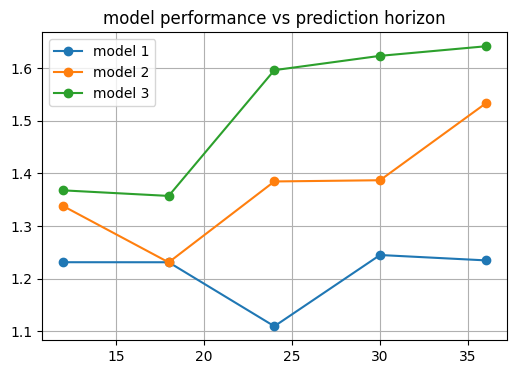

In [ ]:

horizons = [12, 18, 24, 30, 36]
plt.figure(figsize=(6, 4))
plt.plot(horizons, mae1, marker='o', label='model 1')
plt.plot(horizons, mae2, marker='o', label='model 2')
plt.plot(horizons, mae3, marker='o', label='model 3')
plt.title("model performance vs prediction horizon")
plt.legend()
plt.grid(True)
plt.show()

We can see that the model 3 deteriorates the fastest, then the the model 2 also deteriorates as the length of target increasing. However, the maes for model 1 decreased and then, increased back to the similar level as the first point.



No matter from the first point or the avarage value of the 5 maes, the model 1 has the lowest average mae on test set, so this model has the best generalization, it can learn the temperature
patterns from one weather station to predict the temperatures in another weather station the best, following with the model 2, model 3 is the worst.

In [ ]:
train_seq_84 = tf.concat([x_train_n, y_train_n], axis=1)
val_seq_84   = tf.concat([x_val_n, y_val_n], axis=1)
test_seq_84  = tf.concat([x_test_n, y_test_n], axis=1)

train_max = train_seq_84[:, :, 1]
val_max   = val_seq_84[:, :, 1]
test_max  = test_seq_84[:, :, 1]

print(train_max.shape, val_max.shape, test_max.shape)
print(type(train_max))

(1490, 84) (109, 84) (105, 84)
<class 'tensorflow.python.framework.ops.EagerTensor'>


In [ ]:
class Sampling(tf.keras.Layer):
  def call(self, inputs):
    mean, logvar = inputs
    # sum the losses over all the features
    loss = -0.5 * tf.reduce_sum(1 + logvar - tf.exp(logvar) - tf.square(mean), axis=-1)
    # average over instances in the minibatch.
    self.add_loss(tf.reduce_mean(loss) / 84.)
    return tf.random.normal(tf.shape(logvar)) * tf.exp(logvar / 2) + mean


In [ ]:
codings_size = 16

Z = inputs = tf.keras.Input(shape=[84])

Z = tf.keras.layers.Dense(32, activation="leaky_relu")(Z)
Z = tf.keras.layers.Dense(16, activation="leaky_relu")(Z)
codings_mean = tf.keras.layers.Dense(codings_size)(Z) # mu
codings_log_var = tf.keras.layers.Dense(codings_size)(Z) # gamma
codings = Sampling()([codings_mean, codings_log_var])
vae_encoder = tf.keras.Model(
inputs=inputs, outputs=[codings_mean, codings_log_var, codings])


# the decoder part of the VAE
decoder_inputs = tf.keras.Input(shape=[codings_size])
x = tf.keras.layers.Dense(16, activation="leaky_relu")(decoder_inputs)
x = tf.keras.layers.Dense(32, activation="leaky_relu")(x)
outputs = layers.Dense(84)(x)


vae_decoder = tf.keras.Model(inputs=decoder_inputs, outputs=outputs)


In [ ]:
# now join the encoder and decoder together to form our VAE
_, _, codings = vae_encoder(inputs)
reconstructions = vae_decoder(codings)
vae = tf.keras.Model(inputs=inputs, outputs=reconstructions)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=10,
    restore_best_weights=True
)

# compile and train our VAE to minimize the total loss (latent loss + reconstruction loss)
vae.compile(loss="mse", optimizer="nadam",metrics=['mae'])

history_vae = vae.fit(
    train_max, train_max,
    epochs=100,
    batch_size=32,
    validation_data=(val_max, val_max),
    callbacks=[early_stopping_cb],
    verbose=0
)

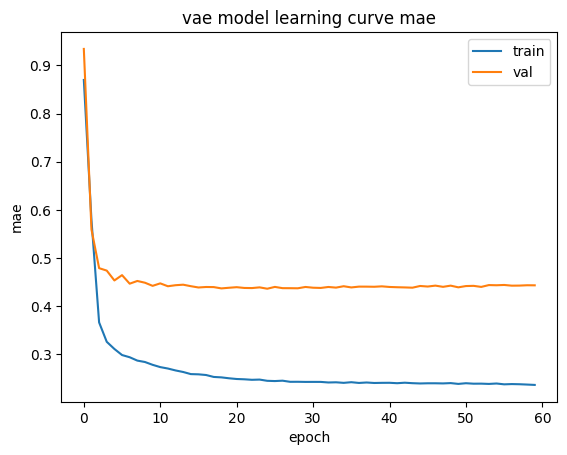

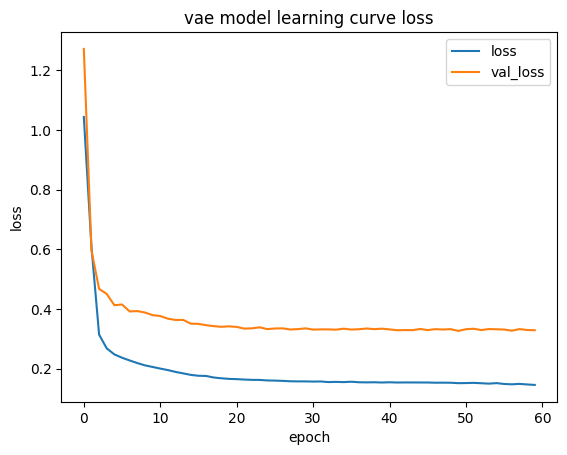

In [ ]:
plt.plot(history_vae.history['mae'], label='train')
plt.plot(history_vae.history['val_mae'], label='val')
plt.legend()
plt.title('vae model learning curve mae')
plt.xlabel('epoch')
plt.ylabel('mae')
plt.show()

plt.plot(history_vae.history['loss'], label='loss')
plt.plot(history_vae.history['val_loss'], label='val_loss')
plt.legend()
plt.title('vae model learning curve loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

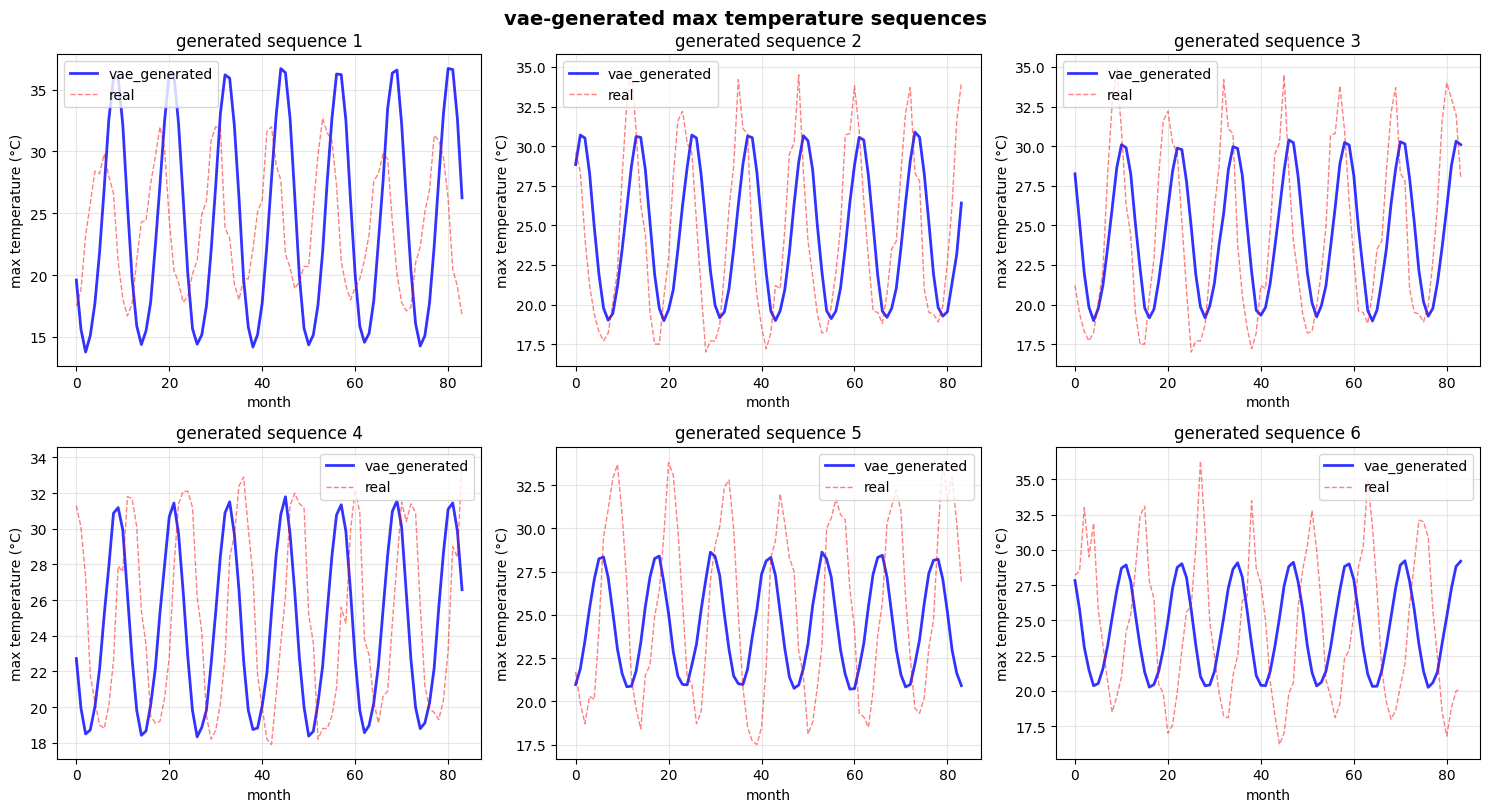

In [ ]:
#sample 6 latent vectors
n_samples = 6
random_latent_vectors = np.random.normal(size=(n_samples, codings_size))

#generate
generated_sequences_scaled = vae_decoder.predict(random_latent_vectors, verbose=0)

#inverse transform
generated_full = np.zeros((n_samples, 84, 2))
generated_full[:, :, 1] = generated_sequences_scaled
generated_sequences = scaler.inverse_transform(generated_full.reshape(-1, 2)).reshape(n_samples, 84, 2)[:, :, 1]


#visualization
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

months = np.arange(84)
real_samples = train_seq[:6, :, 1].numpy()

for i in range(n_samples):
    axes[i].plot(months, generated_sequences[i], 'b-', linewidth=2,
                label='vae_generated', alpha=0.8)
    axes[i].plot(months, real_samples[i], 'r--', linewidth=1,
                label='real', alpha=0.5)

    axes[i].set_xlabel('month')
    axes[i].set_ylabel('max temperature (°C)')
    axes[i].set_title(f'generated sequence {i+1}')
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle('vae-generated max temperature sequences',
             fontsize=14, fontweight='bold', y=1.01)
plt.show()


Overall, the model aligns with the original data's cosine or sine-like waving pattern. However,some examples looks like having a lagging, the peaks comes early or later than the original data. Some examples shows completely opposite wave compared to the original data: when the original data is high, the predicted data is low, and vice versa. Additionally, the domain of some examples appears constrained.